#Install Dependencies

In [1]:
!pip install tensorflow==2.14 tensorflow-metal==1.1 opencv-python-headless matplotlib

In [2]:
import sys
print(sys.executable)

/Users/gabrielschull/anaconda3/envs/facialrecognition/bin/python


In [3]:
#import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt


In [4]:
#import tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [5]:
#Set GPU Memory Consumption Growth to avoid OOM errors -> wrong tensorflow version for this, not necessary though
gpus = print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Num GPUs Available:  1


In [6]:
#Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [7]:
#Make dirs
#os.makedirs(POS_PATH)
#os.makedirs(NEG_PATH)
#os.makedirs(ANC_PATH)

In [8]:
#Collecting labelled faces in the wild dataset at http://vis-www.cs.umass.edu/lfw/ (as gzipped tar file)

In [9]:
#uncompress Tar Labelled Faces in the Wild dataser
#!tar -xf lfw.tar

In [10]:
# Move lfw imgs to the following repo data/negative
#for directory in os.listdir('lfw'):
   # for file in os.listdir(os.path.join('lfw', directory)):
       # EX_PATH = os.path.join('lfw', directory, file)
       # NEW_PATH = os.path.join(NEG_PATH, file)
       # os.replace(EX_PATH, NEW_PATH)
    

In [11]:
import uuid

In [12]:
#Collect positive and anchor classes

# cap = cv2.VideoCapture(0) #Establish a connection to the webcam
# while cap.isOpened():
#     ret, frame = cap.read() 
    
#     #cut down to 250x250px frame
#     frame = frame[250:250+250,475:475+250,:]

#     key = cv2.waitKey(1) & 0XFF

#     #collect anchors
#     if key == ord('a'):
#         #create unique filepath
#         imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
#         #write out anchor image
#         cv2.imwrite(imgname, frame)
#         break

#     #collect positives
#     if key == ord('p'):
#         #create unique filepath
#         imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
#         #write out positive image
#         cv2.imwrite(imgname, frame)
#         break
        
        
#     #show image back to screen
#     cv2.imshow('Image Collection', frame)

#     #breaking if q hit on keyboard after 1 ms
#     if key == ord('q'):
#         break
# #release webcam & close the image show frame
# cap.release()
# cv2.destroyAllWindows()
# cv2.waitKey(1)

In [13]:
#plt.imshow(frame)

In [14]:
#Load and preprocess Images
# get image directories
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(100)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(100)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(100)

2024-02-28 11:46:02.901060: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-02-28 11:46:02.901077: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-28 11:46:02.901080: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-28 11:46:02.901104: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-28 11:46:02.901118: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
dir_test = anchor.as_numpy_iterator()

In [16]:
print(dir_test.next())

b'data/anchor/cdce0b20-d2a2-11ee-944e-563466da705a.jpg'


In [17]:
#Preprocessing - scale and resize

def preprocess(file_path):

    # read in image from file path
    byte_img = tf.io.read_file(file_path)
    # load in the image
    img = tf.io.decode_jpeg(byte_img)
    # preprocessing steps - resize image to be 105x105x3
    img = tf.image.resize(img, (105,105))
    # scale image to be between 0 and 1
    img = img / 255.0

    
    return img

In [18]:
#dataset.map(preprocess)

In [19]:
# Create labelled dataset
# (anchor, positive) =>  1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [20]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [21]:
samples = data.as_numpy_iterator()

In [22]:
example = samples.next()

In [23]:
example

(b'data/anchor/8d97d5ae-d2a2-11ee-aa4a-563466da705a.jpg',
 b'data/positive/f3a1d386-d2a2-11ee-ab5a-563466da705a.jpg',
 1.0)

In [24]:
# Build Train and Test Partition
def preprocess_twin(input_img, validation_img, label):
     return (preprocess(input_img), preprocess(validation_img), label)

In [25]:
preprocess_twin(*example)

(<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
 array([[[0.5467832 , 0.48795965, 0.39776355],
         [0.53582776, 0.47728428, 0.38624784],
         [0.51959676, 0.47001693, 0.36450806],
         ...,
         [0.52576584, 0.4669423 , 0.38458937],
         [0.53760177, 0.47877818, 0.39642525],
         [0.5092437 , 0.4504202 , 0.36806726]],
 
        [[0.5368815 , 0.47805792, 0.38786185],
         [0.55470186, 0.49615848, 0.40512207],
         [0.52873147, 0.47737765, 0.37541685],
         ...,
         [0.49924642, 0.4404229 , 0.35863015],
         [0.5089436 , 0.45012006, 0.36832735],
         [0.48161268, 0.42278916, 0.34099644]],
 
        [[0.5453515 , 0.48652798, 0.3963319 ],
         [0.5184874 , 0.46019745, 0.36941445],
         [0.52648175, 0.47707087, 0.37865815],
         ...,
         [0.4792339 , 0.42041036, 0.34590057],
         [0.4694745 , 0.41065097, 0.33614114],
         [0.48676363, 0.4279401 , 0.3534303 ]],
 
        ...,
 
        [[0.79144335, 0.75222766

In [26]:
# Build dataLoader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [27]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [28]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [29]:
train_samples = train_data.as_numpy_iterator()

In [30]:
train_sample = train_samples.next()

In [31]:
len(train_sample[0])

16

In [32]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [33]:
inp = Input(shape=(105,105,3), name='input_image')

In [34]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [35]:
m1 = MaxPooling2D(64,(2,2), padding='same')(c1)

In [36]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64,(2,2), padding='same')(c2)

In [37]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64,(2,2), padding='same')(c3)

In [38]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [39]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [40]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

In [41]:
# Build embedding layer
def make_embedding():
    inp = Input(shape=(105,105,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64,(2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64,(2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64,(2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')


In [42]:
embedding = make_embedding()

In [43]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 21, 21, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 18, 18, 128)       26

In [44]:
# Build distance Layer
# Siamese L1 Distance class
class L1Dist(Layer):

    # Init inheritance
    def __init__(self, **kwargs):
        super().__init__()
        
    # Compare similarity
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [45]:
l1 = L1Dist()

In [46]:
#l1(anchor_embedding, validation_embedding)

In [47]:
input_image = Input(name='input_img', shape=(105,105,3))
validation_image = Input(name='validation_img', shape=(105,105,3))

In [48]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [49]:
siamese_layer = L1Dist()

In [50]:
distances = siamese_layer(inp_embedding, val_embedding)

In [51]:
classifier = Dense(1, activation='sigmoid')(distances)

In [52]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [53]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [54]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 105, 105, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [55]:
def make_siamese_model():

    # Anchor image inputs in network
    input_image = Input(name='input_img', shape=(105,105,3))
    # Validation image in network
    validation_image = Input(name='validation_img', shape=(105,105,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classificaiton layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [56]:
siamese_model = make_siamese_model()

In [57]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 105, 105, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [58]:
#Training

In [59]:
# Set up Loss and Optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [60]:
# Define optimizer
opt = tf.keras.optimizers.legacy.Adam(1e-4)

In [61]:
# Establish checkpoints
checkpoint_dir = './training.checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [62]:
# Build train step function
@tf.function
def train_step(batch):
    with tf.device('/cpu:0'):
        with tf.GradientTape() as tape:
            # Get anchor and positive/negative image
            X = batch[:2]
            # Get label
            y = batch[2]

            # Forward pass
            yhat = siamese_model(X, training=True)
            #Calculate loss
            loss = binary_cross_loss(y, yhat)
        tf.print('loss:', loss)

        # Calculate gradients
        grad = tape.gradient(loss, siamese_model.trainable_variables)
        # Calculate updated weights and apply to siamese model
        opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        # Return loss
        return loss
    

In [63]:
# Build training 
def train(data, EPOCHS):
    
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step
            train_step(batch)
            progbar.update(idx+1)
            
        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
    
            
        

In [64]:
#Train the model
EPOCHS = 50

In [65]:
train(train_data, EPOCHS)


 Epoch 1/50


2024-02-28 11:46:03.741045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


loss: 0.693596363
9/9 [==============================] - 28s 3s/step

 Epoch 2/50
loss: 0.440075517
9/9 [==============================] - 29s 3s/step

 Epoch 3/50
loss: 0.266921937
9/9 [==============================] - 27s 3s/step

 Epoch 4/50
loss: 0.148034632
9/9 [==============================] - 27s 3s/step

 Epoch 5/50
loss: 0.0487428717
9/9 [==============================] - 26s 3s/step

 Epoch 6/50
loss: 0.0768446624
9/9 [==============================] - 26s 3s/step

 Epoch 7/50
loss: 0.0917860866
9/9 [==============================] - 28s 3s/step

 Epoch 8/50
loss: 0.0282898936
9/9 [==============================] - 26s 3s/step

 Epoch 9/50
loss: 0.0295728557
9/9 [==============================] - 27s 3s/step

 Epoch 10/50
loss: 0.00845563132
9/9 [==============================] - 26s 3s/step

 Epoch 11/50
loss: 0.0138624255
9/9 [==============================] - 27s 3s/step

 Epoch 12/50
loss: 0.00427395478
9/9 [==============================] - 27s 3s/step

 Epoch 13/50
lo

In [84]:
# Evaluate Model
# Import metric calculations
# Precision -> proportion of positive identifications were correct; Recall -> proportion of actual positives correctly identified
from tensorflow.keras.metrics import Precision, Recall

In [85]:
#Make Predictions
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [86]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 20ms/step


array([[9.99770701e-01],
       [9.99998569e-01],
       [6.09581946e-07],
       [1.49814794e-09],
       [1.39899706e-11],
       [9.99999166e-01],
       [1.06384505e-04],
       [2.07898920e-09],
       [1.00000000e+00],
       [4.60628691e-08],
       [9.99981761e-01],
       [3.12580646e-08],
       [6.03145054e-08],
       [9.99234080e-01],
       [9.99974728e-01],
       [9.33285946e-08]], dtype=float32)

In [87]:
# Post processing the results, covert to either 0 or 1
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0]

In [88]:
y_true

array([1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0.],
      dtype=float32)

In [89]:
# Calculate metrics
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

#Return Recall Result
m.result().numpy()


1.0

In [90]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

#Return Recall Result
m.result().numpy()

1.0

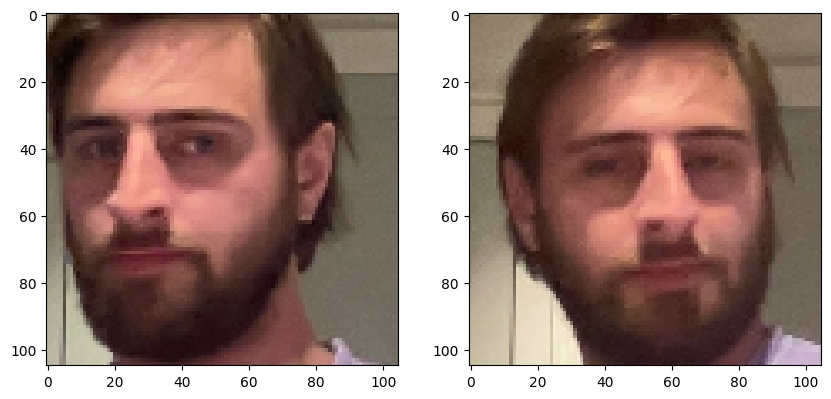

In [105]:
# Visualize Results
# Set plot size
plt.figure(figsize=(10,8))
# Set first subplot
plt.subplot(1,2,1)
# Switch the indexes to see compared images (match to yhat and y_true indexes  as seen in above predictions and post-processing to see where they were validated or not)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
# Switch the indexes to see compared images (match to yhat and y_true indexes  as seen in above predictions and post-processing to see where they were validated or not)
plt.imshow(test_val[0])
# Render
plt.show()

In [108]:
 # Save Model
siamese_model.save('siamesemodel.h5')

In [109]:
# Reload Model
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})